# Path discovery, all friends with all


In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx
# import scipy
import matplotlib.pyplot as plt


# import clique_discovery 
# from helpers import *

In 2020-01-23-single-paths, my specific goal were to isolate all single paths in the traces, i.e. find the longest sequences of symbols that appears consequtively in a set of traces. I succeed in:

* Identify nodes that belong to some loop
* Change successors_pairs to include only just the closest pairs
* In [LoopProblem Notebook](./2020-01-20-LoopProblem.ipynb) , I wrote several attemps of formalization.

Today, I will include the idea of *consider first appearance order* in every single trace. Also I will test backwards valid traces as in 

```
ABC
CBA
```


In [2]:
def graph(G, color="#cccccc", with_weigths=True):
    pos = nx.circular_layout(G)
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.subplot(111)

    nx.draw_networkx (G, pos, width=1, node_color=color, with_labels=True, connectionstyle='arc3, rad=0.03' )
    if with_weigths:
        weights = { (str(u), str(v)): G[u][v]['weight'] for u,v in G.edges() }
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=weights)
    plt.show()

In [3]:
def naive_graph( T, with_weigths=False ):
    NAIVE=nx.DiGraph()
    NAIVE.add_edges_from( [ (a,b) for t in T for a,b in zip( t[:-1], t[1:] )  ] )
    graph( NAIVE, with_weigths=with_weigths )

In [4]:
def get_successor_by_freq( traces ):
    """
    Get successor pairs in every T in traces, and combine them by frequency of appearance.
    
    >>> T = [ list("ABC"), list("ABCABC") ]
    >>> get_successor_pairs_by_freq(T)
    {('A', 'B'): 3, ('A', 'C'): 3, ('B', 'C'): 3, ('B', 'A'): 1, ('C', 'A'): 1, ('C', 'B'): 1}
    """
    pairs_with_freq = {}
    L = float(len(traces))

    for trace in traces:
        for pair in get_successor_pairs(trace):
            if pair in pairs_with_freq.keys():
                pairs_with_freq[pair] = pairs_with_freq[pair] + 1.0/L
            else:
                pairs_with_freq[pair] = 1.0/L
            
    By_freq = {}
    for (u, v), freq in pairs_with_freq.items():
        f = round(freq,2)
        if f in By_freq.keys():
            By_freq[f].append( (u,v) )
        else:
            By_freq[f] =[ (u,v) ]
    return By_freq

In [5]:
# Including Modifications by Andres (20200124)
def get_successor_pairs( T_prime ):
    """
    Get near successor pairs
    
    Given the trace $T' = s_1 ... s_L$
    For every $1 <= i <= L$ find the maximal subtrace starting at $i$
    $T_i_j = s_i ... s_j$ such that $s_i \ne s_k$ for all $i < k <= j$
    
    Return the concatenation for all $T_i_j$
    [ (s_i, s_k) ] for all s_i \in T_i_j, s_k \in T_i_j for all i < k <= j
    
    ADDED 2020-01-23:
    Que no se repitan!

    
    >>> get_successor_pairs(list("ABCD"))
    [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
    """
    pairs = []
    for i in range(0, len(T_prime)-1):


        partial_subtrace = T_prime[i:]

        s_i = partial_subtrace.pop(0)
        L = len(partial_subtrace)

        # Find first first j such s_i == s_j, or L if not exists
        if s_i in partial_subtrace:
            j = partial_subtrace.index(s_i)
        else:
            j = L

        # This is the subtrace T_i_j, the maximal that not contains s1
        # (Actually, it not contains s_i)
#         T_i_j=partial_subtrace[:j] # 2020-01-20 Old BEHAVIOR
        T_i_j=partial_subtrace[:L] # Andres 20200124 .. all friends with all, including loops
        
        T_i_j_pairs = [] # 2020-01-23 BEHAVIOR ... but not remove, it doesn't affect

        # Construct all s_i, s_k , i < k <= j
        for s_k in T_i_j:
            e = (s_i, s_k)

            pairs.append(e)       # 2020-01-20 Old BEHAVIOR
            
#             if e not in T_i_j_pairs:  # 2020-01-23 BEHAVIOR
#                 T_i_j_pairs.append(e) # 2020-01-23 BEHAVIOR
#         pairs += T_i_j_pairs          # 2020-01-23 BEHAVIOR
            
            
            # Added 2020-01-18: global star / end
#             if ADD_START_END:
#                 pairs.append( ("_START_", s_i) )
#                 pairs.append(( s_k, "_END_") )


    return pairs

## Remember succesors from 2020-01-23

In [6]:
# A single path is shown as a complete graph 
get_successor_by_freq([list("ABC")])

{1.0: [('A', 'B'), ('A', 'C'), ('B', 'C')]}

In [7]:
# Note that in a loop the path appears inverted
get_successor_by_freq([list("ABCABC")])

{3.0: [('A', 'B'), ('A', 'C'), ('B', 'C')],
 1.0: [('A', 'A'), ('B', 'A'), ('B', 'B'), ('C', 'A'), ('C', 'B'), ('C', 'C')]}

In [8]:
# Note what happens when noise is introduced
get_successor_by_freq([list(".ABAB")]), \
get_successor_by_freq([list("AB.AB")]), \
get_successor_by_freq([list("ABAB.")])

({2.0: [('.', 'A'), ('.', 'B')],
  3.0: [('A', 'B')],
  1.0: [('A', 'A'), ('B', 'A'), ('B', 'B')]},
 {3.0: [('A', 'B')],
  1.0: [('A', '.'),
   ('A', 'A'),
   ('B', '.'),
   ('B', 'A'),
   ('B', 'B'),
   ('.', 'A'),
   ('.', 'B')]},
 {3.0: [('A', 'B')],
  1.0: [('A', 'A'), ('B', 'A'), ('B', 'B')],
  2.0: [('A', '.'), ('B', '.')]})

In [9]:
# Here the symbols are merged simulating parallel execution, when no order is guaranteed between processes
get_successor_by_freq([list("1A2BA1B2")])

{2.0: [('1', 'A'), ('A', '1'), ('2', 'B'), ('B', '2')],
 3.0: [('1', '2'), ('1', 'B'), ('A', '2'), ('A', 'B')],
 1.0: [('1', '1'),
  ('A', 'A'),
  ('2', 'A'),
  ('2', '1'),
  ('2', '2'),
  ('B', 'A'),
  ('B', '1'),
  ('B', 'B')]}

## Simple Loop

In [10]:
T = [
    list("ABCDABCD"),
]

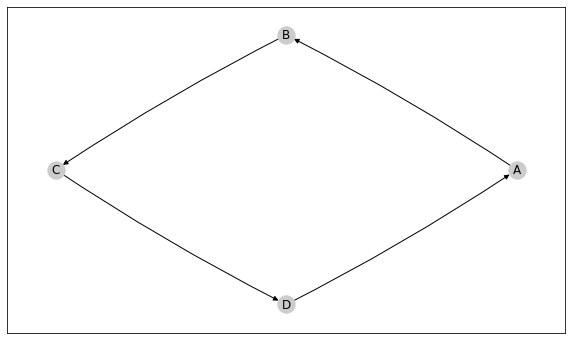

In [11]:
# This graph is a simple loop.
naive_graph(T)

In [12]:
# # Build an auxiliary graph for one frequency
def successors_in_one_freq( successor_pairs_f ):
    G={}
    for f, pairs in successor_pairs_f.items():
        G[f] = nx.DiGraph()
        for p in pairs:
            G[f].add_edge(p[0], p[1], weight=f )
    return G

In [13]:
# The list T has only one item, then the pairs below represents that single path.
succ_of_T = get_successor_by_freq(T)

In [14]:
def successorsGraph(successor_by_freq):
    G=nx.DiGraph()
    for f, pairs in successor_by_freq.items():
        for u, v in pairs:
            G.add_edge(u, v, weight=f)
    return G

Let's build the graph of all $(u,v)$ in successor_by_freq

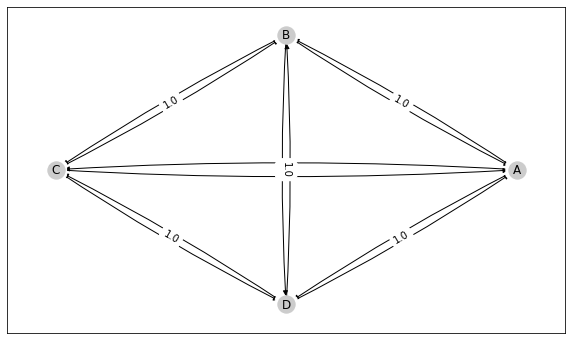

{3.0: [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')],
 1.0: [('A', 'A'),
  ('B', 'A'),
  ('B', 'B'),
  ('C', 'A'),
  ('C', 'B'),
  ('C', 'C'),
  ('D', 'A'),
  ('D', 'B'),
  ('D', 'C'),
  ('D', 'D')]}

In [15]:
bigG = successorsGraph(succ_of_T)

graph(bigG)
succ_of_T

Search cliques in the same frequency. But now, extracting the loops in each trace. Let's build a list of *G_freq[f]*

In [16]:
# # Now with the complex T
G_freq = successors_in_one_freq(succ_of_T) # { f: successors_graph(pairs, f) for f, pairs in succ_of_T.items() }

Cliques in $G_{freq}$ are the set of vertex:

In [17]:
{ f: list(nx.algorithms.clique.find_cliques( G_freq[f].to_undirected() )) for f in G_freq.keys() }

{3.0: [['A', 'D', 'C', 'B']], 1.0: [['A', 'D', 'C', 'B']]}

In [18]:
# Sort the cliques and apply the rules:
# 1) The nodes of a single path in their equivalent pair has in_degree=0,1,2,...
# 2) A path is composed for at least 2 nodes

def infer_paths(G_freq, min_clique_size=2):

    paths_f = {}
    cliques_f = { f: list(nx.algorithms.clique.find_cliques( G_freq[f].to_undirected() )) for f in G_freq.keys() }
    for f, cliques in cliques_f.items():
        paths = []
        for clique in cliques:
            # From the original graph(f),
            G_complete = G_freq[f].copy()
            
            # remove the nodes not in this clique 
            for node in set(G_complete.nodes).difference( set(clique) ):
                G_complete.remove_node(node)
                
            # Order nodes by inner degree
            nodes = sorted( G_complete.in_degree() , key=lambda p: p[1], reverse=False)

            # - core - CRITERIA 1 and 2
            # Strict checking: in_degree(n) in [0, ... , len(N)-1]
            if len(nodes) >=min_clique_size and all( 
                [in_degree == i for i, (a, in_degree) in zip(range(0, len(nodes)), nodes)]
            ):
                    paths.append ( [ a for a, in_degree in nodes ] )
        if paths:
            paths_f[f] = paths
    return paths_f

Sort the cliques, let's assume that a path is composed for at least 2 nodes and apply the rule:

**Claim (1)**: The nodes of a single path in their equivalent pair graph can be ordered by in_degree, starting at 0. $in\_degree=0,1,2,...$ 

In [19]:
infer_paths(G_freq)

{3.0: [['A', 'B', 'C', 'D']]}

But see that the inferred paths appears duplicated and inverted. Let's introduce the **precedence graph** to retain who appears first in each trace. Given a single grace $t$, the $uniques(t)$ is obtained by adding each sequence symbol in $t$ if not already in $uniques(t)$.

$t = pqrstqrstqr \longrightarrow uniques(t) = pqrst$

Clearly $uniques(t)$ defines a serial path, then the successors graph of $unique(t)$ can be used to retain the precedence. 

In [20]:
def unique_single_trace( T ):
    uT = []
    for s in T:
        if s not in uT:
            uT.append(s)
    return uT
    

In [21]:
unique_single_trace( list("pqrstqrstqr") )

['p', 'q', 'r', 's', 't']

In [22]:
uniqueT = unique_single_trace( T[0] )
uniqueT

['A', 'B', 'C', 'D']

In [23]:
# uniqueG = successorsGraph( get_successor_by_freq(unique_single_trace( list("ABCACB") )) )
# graph(uniqueG)
# get_successor_by_freq([unique_single_trace( list("ABCACB") )])

In [24]:
def split_in_freqGraph( successorsGraph ):
    u_v_f = [ (u, v, successorsGraph[u][v]["weight"]) for u, v in successorsGraph.edges]
    frqs = set([ f for u, v, f in u_v_f])
    G={}
    for f in frqs:
        G[f] = successorsGraph.copy()
        # Get all nodes whose pairs has weight!=f
        for u, v, f2 in u_v_f:
            if f != f2:
                G[f].remove_edge(u,v)
        # Remove 
    return G

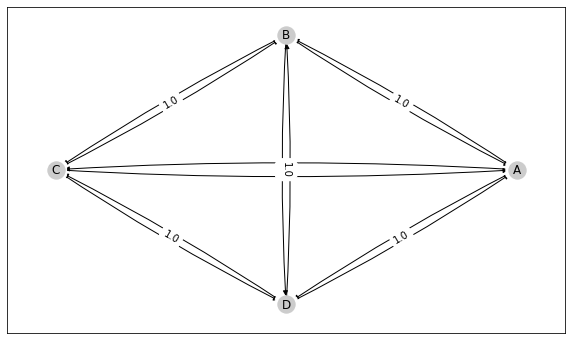

{3.0: [['A', 'B', 'C', 'D']]}

In [25]:
# Now all together:
T = [
    list("ABCDABCD"),
]
bigG = successorsGraph(  get_successor_by_freq(T)  )
G_freq = split_in_freqGraph( bigG )

# for f, G in G_freq.items():
#     graph(G)
graph(bigG)

infer_paths(G_freq)

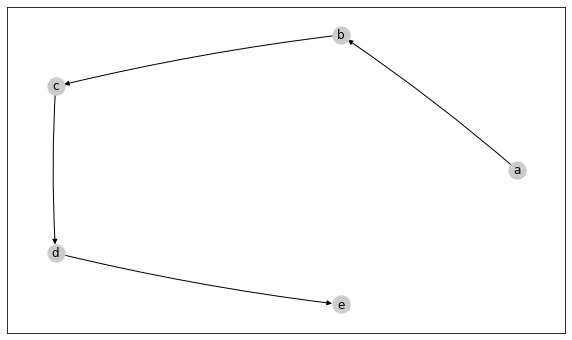

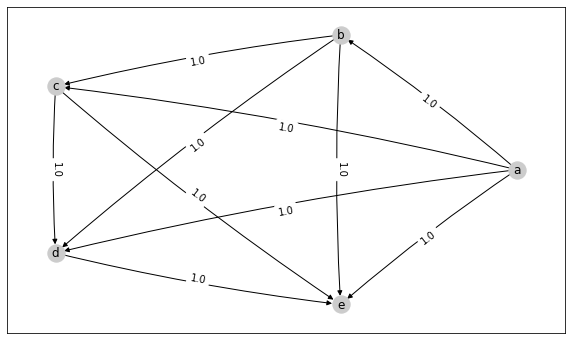

{1.0: [['a', 'b', 'c', 'd', 'e']]}

In [26]:
# Single path again, using the clique method
T = [
    list("abcde")
]
bigG = successorsGraph(  get_successor_by_freq(T)  )

naive_graph(T)
graph(bigG)
infer_paths(  split_in_freqGraph( bigG ) )

## Multiple traces , no loop

In [27]:
# Expected paths: ABC 123
T = [
    list("ABC123"),
    list("123ABC"),    
]
bigG = successorsGraph(  get_successor_by_freq(T)  )
infer_paths( split_in_freqGraph( bigG ) )

{1.0: [['A', 'B', 'C'], ['1', '2', '3']]}

In [28]:
# Expected paths: ABC 123
T = [
    list("ABC123"), list("ABC123"),
    list("123ABC"), list("123ABC"),
    list("123"), list("123"), list("123"), list("123"), list("123"), 
]
bigG = successorsGraph(  get_successor_by_freq(T)  )
infer_paths( split_in_freqGraph( bigG ) )

{0.44: [['A', 'B', 'C']], 1.0: [['1', '2', '3']]}

### No-regret restricion

I have to understand why. But my method has the restriction that if path $P = p_1p_2...p_N$ is in the set of traces, then the backwards $P' = p_N..p_2p_1$ is not allowed to be.

This could be a limitation if the logs describes roll-out roll-in actions, as:

1. Check key
1. Open Door
1. Check lights
1. Turno on light
1. Check table
1. Tidy up


In [29]:
# Expected paths: I don't know! This example is interesting.
T = [ list("ABCDDCBA") ]
bigG = successorsGraph(  get_successor_by_freq(T)  )
infer_paths( split_in_freqGraph( bigG ) )

{}

In [30]:
# Expected paths: I don't know! This example is interesting.
T = [ list("ABCD"),
     list("DCBA") 
]
bigG = successorsGraph(  get_successor_by_freq(T)  )
infer_paths( split_in_freqGraph( bigG ) )

{}

## Simple Loops

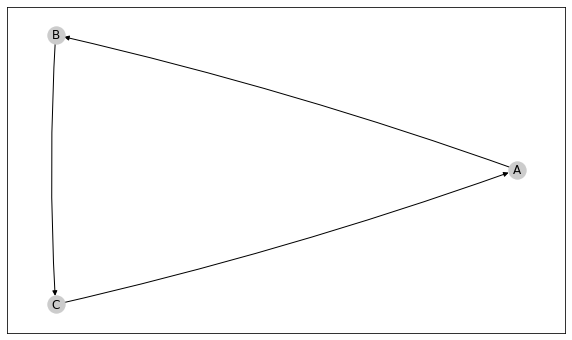

{3.0: [['A', 'B', 'C']]}

In [31]:
# Expected Loops: ABC
T = [
    list("ABCABC")
]
bigG = successorsGraph(  get_successor_by_freq(T)  )
naive_graph(T)
paths = infer_paths( split_in_freqGraph( bigG ) )
paths

Claim (2): If the nodes $V$ makes a loop in a pairs graph $G$ then $| freq(AB) - freq(BA) | = 1$, $\forall A,B \in V(G)$ (2)
```
    ABC ABC ..  ABC ABC = N
    
    AB  AB  ..  AB  AB  = N
     \  / \     / \ / 
     B--A  B..--A B-A   = N-1

    A-C A-C ..  A-C A-C = N
      \ / \     / \ /   
      C-A C-..--A C-A   = N-1
```

In [32]:
# Nodes part of a loop
# Search all n in bigG such that
# | freq(AB) - freq(BA) | = 1 \forall A,B \in V(G)

def is_a_loop_criteria(u, v, bigG):
    return \
        (u,v) in bigG.edges \
        and (v,u) in bigG.edges \
        and  1 == abs( bigG.edges[u,v]['weight'] - bigG.edges[v,u]['weight'] )

    
def loops_from_G( bigG, verbose=False ):
    loops = set()
    for u in bigG.nodes:
        for v in bigG.nodes - u:
            if is_a_loop_criteria(u,v,bigG):
                loops.add(u)
                loops.add(v)
    return loops

In [33]:
# Let's see. 
loops_from_G(bigG, verbose=True)

set()

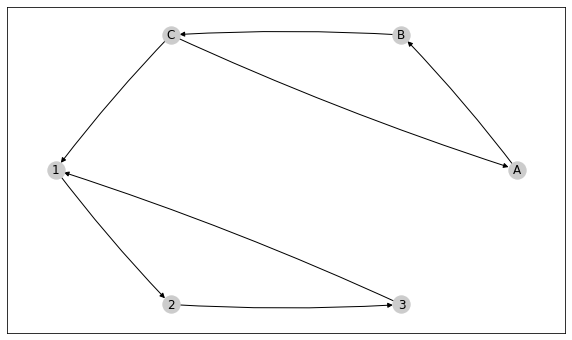

{3.0: [['A', 'B', 'C'], ['1', '2', '3']],
 4.0: [['A', '3'],
  ['A', '2'],
  ['A', '1'],
  ['C', '3'],
  ['C', '2'],
  ['C', '1'],
  ['B', '3'],
  ['B', '2'],
  ['B', '1']]}

In [34]:
# Expected Loops: ABC 123
T = [
    list("ABCABC123123")
]
bigG = successorsGraph(  get_successor_by_freq(T)  )
naive_graph(T)
paths = infer_paths( split_in_freqGraph( bigG ) )
paths

In [35]:
loops_from_G(bigG, verbose=True)

set()

## Tested examples

In [36]:
def evaluate_against (T, expected_paths):
    paths = infer_paths( split_in_freqGraph( successorsGraph(  get_successor_by_freq(T)  ) ) )
    good = []
    bad = []
    expected = [ list(a) for a in expected_paths ]
    for f, paths in paths.items():
        for p in paths:
#             print(paths)
            if p in expected:
                good.append("".join(p))
            else:
                bad.append("".join(p))
            
    if len(expected_paths) != len(good):
        print(), print()
        print("WARNING HERE! OJO AQUI!")
        print(), print()
    print("These %s paths were correctly detected (%s undetected):" % (len(good), len(expected_paths)-len(good)))
    print(good)
    print()
    
    print("These %s paths are spurious:" % len(bad))
    print (bad)
    return good, bad

### Simple Loop Examples

In [37]:
T = [
    list("ABCDABCD"),
]
g, b = evaluate_against(T, ["ABCD"] )

These 1 paths were correctly detected (0 undetected):
['ABCD']

These 0 paths are spurious:
[]


In [38]:
T = [
    list("ABCDABCD"),
    list("1234512345"),
    list("12345")
]
g, b = evaluate_against(T, ["ABCD", "12345"] )

These 2 paths were correctly detected (0 undetected):
['ABCD', '12345']

These 0 paths are spurious:
[]


### Complex Loop Examples

In [40]:
# Type 76
T = [
    list("ABCABCABC123123123123")
]
g, b = evaluate_against(T, ("ABC", "123") )

These 2 paths were correctly detected (0 undetected):
['123', 'ABC']

These 9 paths are spurious:
['A3', 'A2', 'A1', 'C3', 'C2', 'C1', 'B3', 'B2', 'B1']


## Still Failing. Still...

In [48]:
"""
  @def 
       > FG 
  @hjk 
"""        
T = [
    list("defdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("hjk", "def", "FG") )



WARNING HERE! OJO AQUI!


These 2 paths were correctly detected (1 undetected):
['def', 'hjk']

These 6 paths are spurious:
['dFG', 'eFG', 'fFG', 'hFG', 'jFG', 'kFG']


In [49]:
"""
          hjk
  12345 <     > FG
          def 
"""
T = [
    list("12345defFG"),
    list("12345hjklFG")
]
g, b = evaluate_against(T, ("12345FG", "hjkl", "def") )



WARNING HERE! OJO AQUI!


These 1 paths were correctly detected (2 undetected):
['12345FG']

These 14 paths are spurious:
['defG', '2def', '3def', '5def', '1def', 'defF', '4def', 'hjklG', '2hjkl', '3hjkl', '5hjkl', '1hjkl', 'hjklF', '4hjkl']


In [50]:
"""
          @hjk
  12345 <      > FG
          @def 
"""
T = [
    list("12345defdefFG"),
    list("12345hjkhjkFG")
]
g, b = evaluate_against(T, ["12345", "hjk", "def", "FG"] )



WARNING HERE! OJO AQUI!


These 2 paths were correctly detected (2 undetected):
['def', 'hjk']

These 6 paths are spurious:
['12345dFG', '12345eFG', '12345fFG', '12345kFG', '12345hFG', '12345jFG']


In [51]:
# loop_inside = @hjk | ( (12 | 34) - ABC - @def - FG) )
"""
                     
  @hjk ----------- 
                  \
   12               > FG
       > ABC - @def 
   34 
        
"""
T = [
    list("12ABCdefdefFG"),
    list("12ABCdefdefdefFG"),
    list("34ABCdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("ABC", "34", "12", "hjk", "def", "FG") )



WARNING HERE! OJO AQUI!


These 3 paths were correctly detected (3 undetected):
['FG', 'hjk', 'def']

These 42 paths are spurious:
['12A', '12G', '12F', '12B', '12C', 'hG', 'hF', 'jG', 'jF', 'kG', 'kF', '2d', '2f', '2e', '1d', '1f', '1e', 'ABCG', 'ABCF', 'Ad', 'dG', 'dF', 'Bd', 'Cd', 'Ae', 'eG', 'eF', 'Be', 'Ce', 'Af', 'fG', 'fF', 'Bf', 'Cf', '34A', '34G', '34d', '34e', '34F', '34f', '34B', '34C']


In [52]:
"""
          @hjk
  12345 <      > FG
          @def 
          @xyz
"""
T = [
    list("12345defdefxyzxyzFG"),
    list("12345xyzxyzhjkhjkFG"),
    list("12345hjkxyzxyzhjkFG"),

]
g, b = evaluate_against(T, ["12345", "hjk", "def", "xyz", "FG"] )



WARNING HERE! OJO AQUI!


These 2 paths were correctly detected (3 undetected):
['def', 'xyz']

These 76 paths are spurious:
['dG', '2d', '3d', '5d', '1d', 'dF', '4d', 'eG', '2e', '3e', '5e', '1e', 'eF', '4e', 'fG', '2f', '3f', '5f', '1f', 'fF', '4f', '12345FG', 'zG', '2z', '3z', '5z', '1z', 'zF', 'zhjk', '4z', 'xG', '2x', '3x', '5x', '1x', 'xF', 'xhjk', '4x', 'yG', '2y', '3y', '5y', '1y', 'yF', 'yhjk', '4y', 'dx', 'dz', 'dy', 'ex', 'ez', 'ey', 'fz', 'fx', 'fy', 'hG', '2h', '3h', '5h', '1h', 'hF', '4h', 'kG', '2k', '3k', '5k', '1k', 'kF', '4k', 'jG', '2j', '3j', '5j', '1j', 'jF', '4j']
